In [1]:
!pip install colour-science
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import colour
import cv2
import functools

In [2]:
def alter(img, value):
    h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV)) # Split in H, S, V
    v = np.where((v+value >= 0)&(v+value <= 255), v, v+value) # Adds the value, while bounding the value
    return cv2.cvtColor(np.array(np.stack((h,s,v), axis=-1), np.uint8), cv2.COLOR_HSV2BGR) # Merge and convert back to BGR

In [3]:
def cluster(image, clusters):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    clf = MiniBatchKMeans(n_clusters = clusters, batch_size = 4096)
    labels = clf.fit_predict(image.reshape(-1, 3))
    return cv2.cvtColor(clf.cluster_centers_.astype("uint8")[labels].reshape(image.shape), cv2.COLOR_LAB2BGR, cv2.CV_8U)

In [4]:
def cluster_brightened(image, clusters, lighten_value, darken_value):
    return alter(cluster(alter(image, lighten_value), clusters), -darken_value)

In [5]:
standardise_colours = lambda quantized_image: cv2.cvtColor(
    functools.reduce(
        lambda quantized_image,i:np.where(
            np.stack(
                [np.any(
                    quantized_image == functools.reduce(
                        lambda x, j: (colour.delta_E(i, j), j) if(colour.delta_E(i, j) < x[0]) else x, # x is a tuple (max_value, map_colour), find map_colour for min value of colour.delta_E
                        np.unique(quantized_image.reshape(-1, 3), axis=0), # Refers to unique class pairs
                        (float("inf"), 0) # Initial Value, with max_value of inf and map_colour of 0
                    )[-1], # checks for map_colour
                    axis=-1 # Checks if any of the values at pixel-level is equal to map_colour
                )]*3,
            axis=-1), # Makes an image of shape the same as the quantized image, with each pixel having the same L,A,B value 
            np.full(quantized_image.shape,i), # Multiplies each trio to form of a full colour image
            quantized_image # Initial Value is the Image
        ),
        cv2.cvtColor(np.array([[[127,127,127],[128,0,0],[0,0,128]]], np.uint8), cv2.COLOR_BGR2LAB)[0], # unique values
        cv2.cvtColor(quantized_image, cv2.COLOR_BGR2LAB) # Initial Value is quantized_image in L*AB Format
    ), 
    cv2.COLOR_LAB2BGR, cv2.CV_8U # Converts Altered Image back to BGR
)

In [6]:
def cvtImage(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img[img[:,:]==0]=255
  return img

In [21]:
def cluster_test(clustering_function, lighten_value, darken_value):
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    [
      [
        axes[j].imshow(img) for j,img in ( # Plot on Axes
            lambda img: (
                lambda img, q: list(enumerate((
                    img, q, 
                    standardise_colours(q)[:,:,::-1] # Standardized Image
                )))
            )(
                img, # Original Image
                clustering_function(img, 4, lighten_value, darken_value) # Quantized Image
            )
        )(
            cvtImage(cv2.imread(f"image_{i}.png")) # Takes in the Images and converts black to white, BGR to RGB
        )
      ] for i in range(1,2)
    ]
    fig.tight_layout()

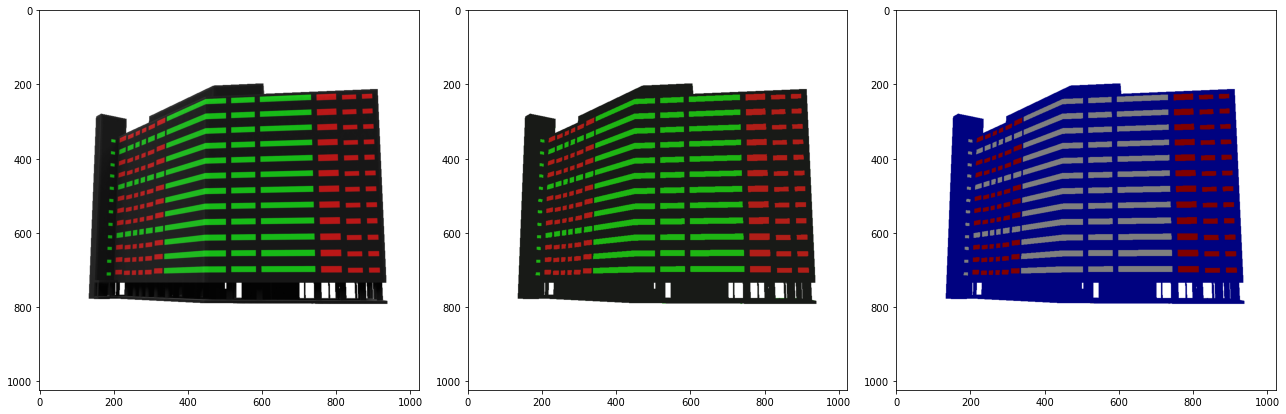

In [23]:
cluster_test(cluster_brightened, 0, 0)

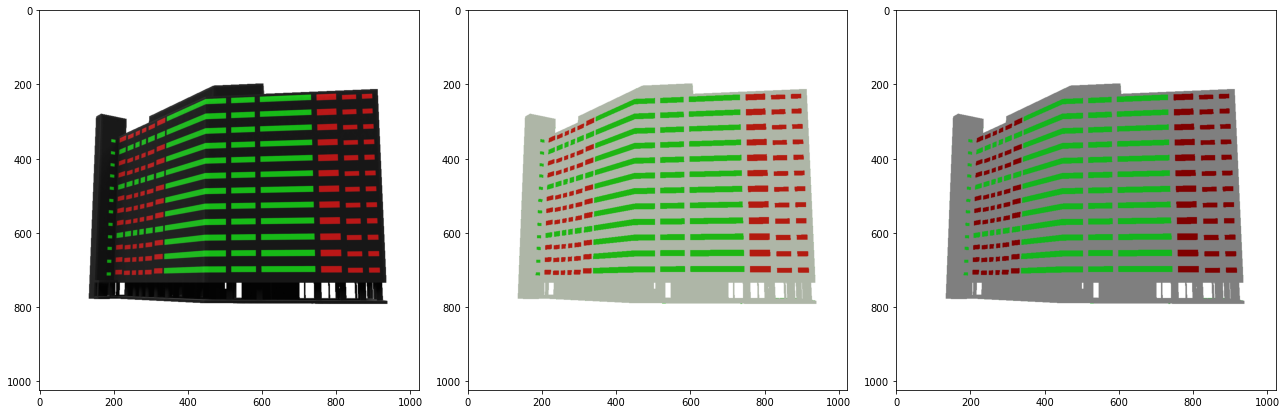

In [22]:
cluster_test(cluster_brightened, 100, 100)

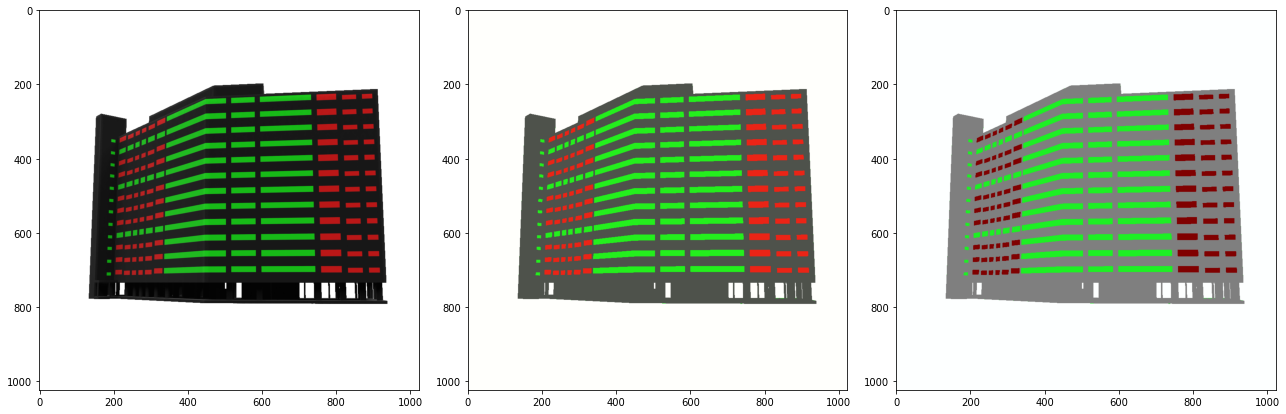

In [24]:
cluster_test(cluster_brightened, 200, 200)

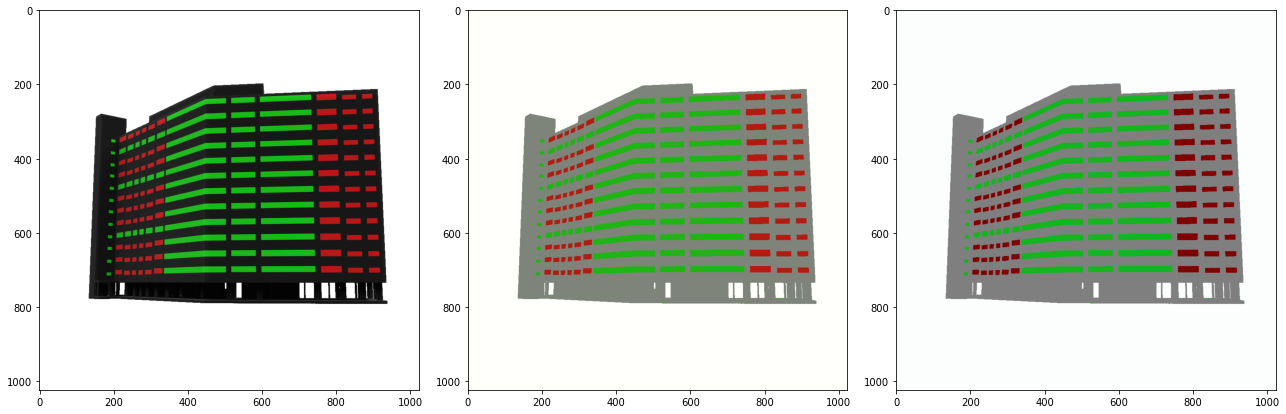

In [25]:
cluster_test(cluster_brightened, 200, 150)